In [1]:
import torch
import torchvision
import os

try:
  from google.colab import drive
  drive.mount('/content/drive')

  os.chdir('/content/drive/MyDrive/GitHub/kornia')
except Exception:   # Not run on Google Colab
  import getpass
  if getpass.getuser() == 'vscode':       # Running in container
    os.chdir('/workspaces/kornia/')
  else:                                   # Running in virtual environment
    os.chdir(os.path.join(os.path.expanduser('~'), 'Documents/Git/kornia/'))

print(os.getcwd())
import sys
sys.path.insert(0, os.getcwd())

from kornia.nerf.camera_utils import parse_colmap_output, cameras_for_ids
from kornia.nerf.nerf_solver import NerfSolver
from torchvision.io import read_image
import matplotlib.pyplot as plt
import glob

Mounted at /content/drive
/content/drive/MyDrive/GitHub/kornia


## Load scene images and plot one of them

In [2]:
scene_name = 'head_sculpture4'
data_dir = 'kornia/nerf/kornia_nerf_data/'

scene_dir = os.path.join(data_dir, scene_name)

img_ext = 'jpeg'

print(f'Scene directory: {scene_dir}, image extensions: {img_ext}')

Scene directory: kornia/nerf/kornia_nerf_data/head_sculpture4, image extensions: jpeg
kornia/nerf/kornia_nerf_data/head_sculpture4/head_sculpture4_spline_path.gif


torch.Size([3, 682, 384])
28


torch.Size([682, 384, 3])

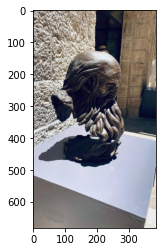

In [ ]:
img_dir = os.path.join(scene_dir, 'images')

img_paths = sorted(glob.glob(f'{img_dir}/*.{img_ext}'))

img0 = read_image(img_paths[0])
print(img0.shape)

imgs: torch.tensor = []
camera_ids = []
num_cams_to_load = -1
for i, img_path in enumerate(img_paths):
    if num_cams_to_load != -1 and i == num_cams_to_load:
        break
    img = read_image(img_path)
    imgs.append(img)
    camera_ids.append(i)

print(len(imgs))
img_plt = torch.permute(imgs[0], (1, 2, 0))
plt.imshow(img_plt)
img_plt.shape

## Parse cameras from estimated pos xml

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
print(device)

colmap_camera_model_path = os.path.join(scene_dir, 'cameras.txt')
colmap_images_model_path = os.path.join(scene_dir, 'images.txt')

img_names, cameras = parse_colmap_output(
    cameras_path=colmap_camera_model_path, 
    images_path=colmap_images_model_path, 
    device=device,
    dtype=torch.float32)

# To use same subset of cameras as input images
cameras = cameras_for_ids(cameras, camera_ids)

print(cameras.batch_size)
for i in range(cameras.batch_size):
  print(f'Intrinsics: \n{cameras.intrinsics[i]}; \nExtrinsics: \n{cameras.extrinsics[i]}')

cuda
28
Intrinsics: 
tensor([[539.7794,   0.0000, 192.0000,   0.0000],
        [  0.0000, 539.7794, 341.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.3525,  0.5124, -0.7831,  2.8293],
        [-0.2425,  0.8582,  0.4524, -3.0092],
        [ 0.9038,  0.0304,  0.4268,  4.8613],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[539.7794,   0.0000, 192.0000,   0.0000],
        [  0.0000, 539.7794, 341.0000,   0.0000],
        [  0.0000,   0.0000,   1.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   1.0000]], device='cuda:0'); 
Extrinsics: 
tensor([[ 0.0772,  0.5137, -0.8545,  3.5698],
        [-0.2523,  0.8392,  0.4818, -3.1750],
        [ 0.9646,  0.1784,  0.1944,  5.9211],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
Intrinsics: 
tensor([[539.7794,   0.0000, 192.0000,   0.0000],
        [  0.0000, 539.7794, 341.

## Run training on image scene

In [5]:
nerf_obj = NerfSolver(device=device, dtype=torch.float32)
num_img_rays = 1024
batch_size = 4096

nerf_obj.init_training(cameras=cameras, min_depth=3., max_depth=10., ndc=False, imgs=imgs, num_img_rays=num_img_rays, 
                       batch_size=batch_size, num_ray_points=128, irregular_ray_sampling=True)

# torch.manual_seed(0)    # For reproducibility of random processes

nerf_obj.run(num_epochs=10000)

Epoch: 0: epoch_psnr = 10.936960220336914; time: 19:01:08
Epoch: 10: epoch_psnr = 12.565690040588379; time: 19:01:51
Epoch: 20: epoch_psnr = 13.416994094848633; time: 19:02:36
Epoch: 30: epoch_psnr = 13.82329273223877; time: 19:03:21
Epoch: 40: epoch_psnr = 14.18898868560791; time: 19:04:05
Epoch: 50: epoch_psnr = 14.3515043258667; time: 19:04:50
Epoch: 60: epoch_psnr = 14.341397285461426; time: 19:05:34
Epoch: 70: epoch_psnr = 14.495044708251953; time: 19:06:19
Epoch: 80: epoch_psnr = 14.688311576843262; time: 19:07:03
Epoch: 90: epoch_psnr = 14.718875885009766; time: 19:07:47
Epoch: 100: epoch_psnr = 14.831602096557617; time: 19:08:31
Epoch: 110: epoch_psnr = 14.846346855163574; time: 19:09:15
Epoch: 120: epoch_psnr = 15.005999565124512; time: 19:09:59
Epoch: 130: epoch_psnr = 14.921873092651367; time: 19:10:43
Epoch: 140: epoch_psnr = 14.969347953796387; time: 19:11:27
Epoch: 150: epoch_psnr = 14.992707252502441; time: 19:12:11
Epoch: 160: epoch_psnr = 15.047368049621582; time: 19:1

KeyboardInterrupt: ignored

In [6]:
# nerf_obj.run(num_epochs=10000)

## Rendering novel views

### Sub-set of input cameras

In [7]:
from kornia.nerf.camera_utils import cameras_for_ids

camera_ids = [0]
cameras_to_render = cameras_for_ids(cameras, camera_ids)

In [8]:
imgs_rendered = nerf_obj.render_views(cameras_to_render)

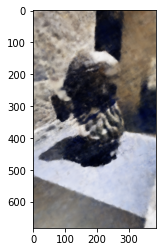

In [9]:
plt.imshow(imgs_rendered[0])

### Spline path pattern

### Spiral pattern

In [10]:
from kornia.nerf.camera_utils import create_spline_curve

cameras_spline_path = create_spline_curve(cameras, 60)
imgs_rendered_spline_path = nerf_obj.render_views(cameras_spline_path)

In [11]:
# nerf_obj._imgs = []
# imgs = []


In [12]:
# from kornia.nerf.camera_utils import create_spiral_path

# cameras_spiral = create_spiral_path(cameras, rad=1., num_views=30, num_circles=2)
# imgs_rendered_spiral = nerf_obj.render_views(cameras_spiral)

### Create movie for output pattern

In [13]:
import numpy as np
import imageio

imgs_rendered_spline_path_numpy = [img_rendered_spline_path.cpu().numpy() for img_rendered_spline_path in imgs_rendered_spline_path]

gif_path = os.path.join(scene_dir, scene_name + '_spline_path.gif')
imageio.mimwrite(gif_path, imgs_rendered_spline_path_numpy, fps=30)

In [14]:
from IPython.display import Image
Image(open(gif_path, 'rb').read())

Output hidden; open in https://colab.research.google.com to view.